In [1]:
import pymaster as nmt
import numpy as np
import healpy as hp
import wget
import os
import matplotlib.pyplot as plt

These notebooks aim to provide a comprehensive review of the functionality implemented in NaMaster. No rigorous mathematical derivations of any statements made will be provided, and users are referred to the references below for further details:
- **A19**. The original NaMaster paper (Alonso et al. 2019 https://arxiv.org/abs/1809.09603).
- **G19**. Garcia-Garcia et al. 2019 (https://arxiv.org/abs/1906.11765), which introduces the basic approximation used by NaMaster to estimate covariance matrix.
- **N20**. Nicola et al. 2020 (https://arxiv.org/abs/2010.09717), which refined these approximations and described in detail the procedure to estimate cosmic shear power spectra.
- **W24**. Wolz et al. 2024 (TBD), which introduced the formalism for catalog-based $C_\ell$s.

# 3 Power spectrum covariances <a class="anchor" id="S3"></a>
This tutorial presents the infrastructure built in NaMaster for the calculation of "Gaussian" or "disconnected" power spectrum covariances. The covariance matrix is a critical ingredient of any scientific analysis, and their accurate estimation is therefore of paramount importance.

It is worth noting that NaMaster's implementation of Gaussian covariances relies on an approximation (the so-called "Narrow Kernel Approximation", NKA) described in detail in G19 and N20. This means that, although the method is highly accurate in most situations of interest in cosmology, it is never a bad idea to test its validity in specific toy scenarios. In particular, care should be taken in the following limits:
* On large scales. The definition of "large" depends on the properties of the footprint under study but, in most common scenarios, problems are normally isolated to $\ell\lesssim10$.
* For $B$-mode power spectra in the presence of strong $E$-modes, particularly for complex masks.
* For very steep spectra in the presence of complex masks.

In addition to these, highly non-Gaussian fields will receive contributions to the covariance matrix that are not captured by NaMaster's Gaussian covariance.

In spite of these caveats, it is worth bearing in mind that in many realistic scenarios, NaMaster's covariance implementation does provide an accurate description of the uncertainty and correlation structure of measured power spectra, usually more stable than the result of running a limited (even if large) number of potentially expensive simulations.

# Table of contents

* [3.1 Gaussian covariance of scalar fields](#Ss3.1)
* [3.2 Power spectrum ordering](#Ss3.2)
* [3.3 Covariance for spin fields](#Ss3.3)

## 3.1 Gaussian covariance of scalar fields <a class="anchor" id="Ss3.1"></a>
The code below generates Gaussian realisations of a power spectrum of the form $C_\ell = 1/(\ell+10)**4$ in the presence of a reasonably complicated sky mask (that used in the analysis of the Quaia sample -- [Storey-Fisher et al. 2023](https://arxiv.org/abs/2306.17749), [Alonso et al. 2023](https://arxiv.org/abs/2306.17748)). Note that we choose a relatively steep spectrum in order to highlight the usefulness of the improved NKA (iNKA) described in N20.

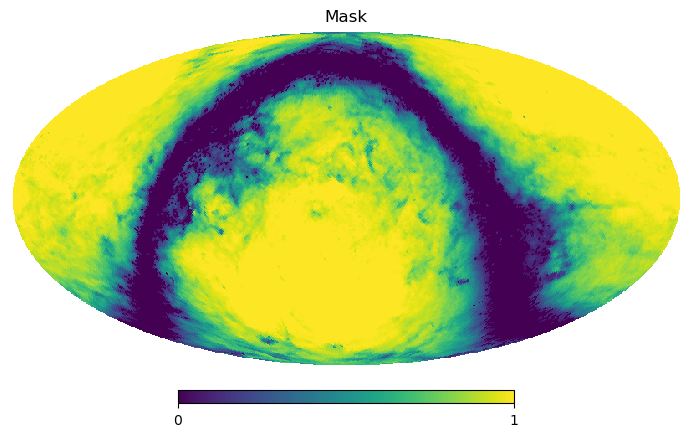

In [2]:
# Read mask
fname_mask = 'selection_function_NSIDE64_G20.5_zsplit2bin0.fits'
if not os.path.isfile(fname_mask):
    wget.download("https://zenodo.org/records/8098636/files/selection_function_NSIDE64_G20.5_zsplit2bin0.fits?download=1")
mask = hp.read_map(fname_mask)

fig = plt.figure(figsize=(7, 5))
hp.mollview(mask, title='Mask', fig=fig)

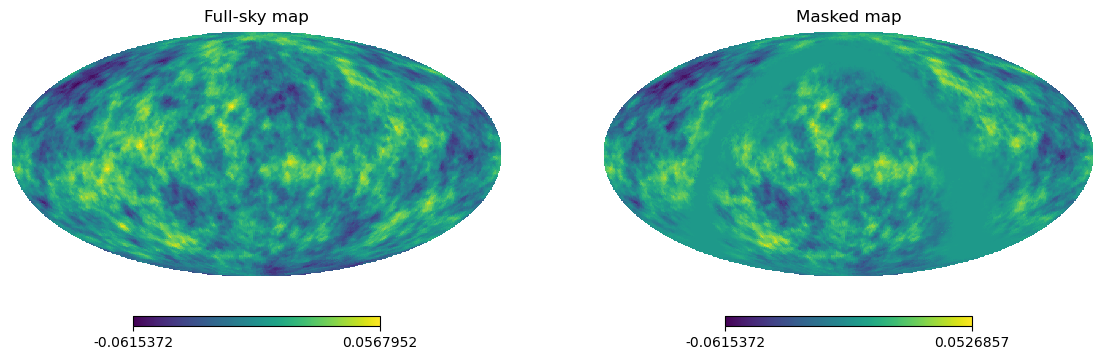

In [3]:
# HEALPix resolution parameter
npix = len(mask)
nside = hp.npix2nside(npix)

# Range of ells to explore and input power spectrum
ls = np.arange(3*nside)
cl_true = 1/(ls+10)**4

# Simulator
def gen_sim():
    return hp.synfast(cl_true, nside)

fig, axes = plt.subplots(1, 2, figsize=(14, 10))
mp = gen_sim()
plt.axes(axes[0])
hp.mollview(mp, title='Full-sky map', hold=True)
plt.axes(axes[1])
hp.mollview(mp*mask, title='Masked map', hold=True)

First, estimate the mode-coupling matrix and the associated covariance coupling coefficients for your mask.

In [4]:
# Binning scheme
b = nmt.NmtBin.from_nside_linear(nside, nlb=4)
leff = b.get_effective_ells()

# Field
f = nmt.NmtField(mask, None, spin=0)

# MCM
w = nmt.NmtWorkspace.from_fields(f, f, b)

# Covariance MCM
cw = nmt.NmtCovarianceWorkspace.from_fields(f, f)
fsky = np.mean(mask**2)

Now run 10000 sims and compute their power spectra and covariance (so we have something to compare against). Note that we estimate both the mode-decoupled power spectrum of each sim and the mode-coupled one (corrected by $f_{\rm sky}$ -- see Tutorial 1), since the latter is used in the iNKA.

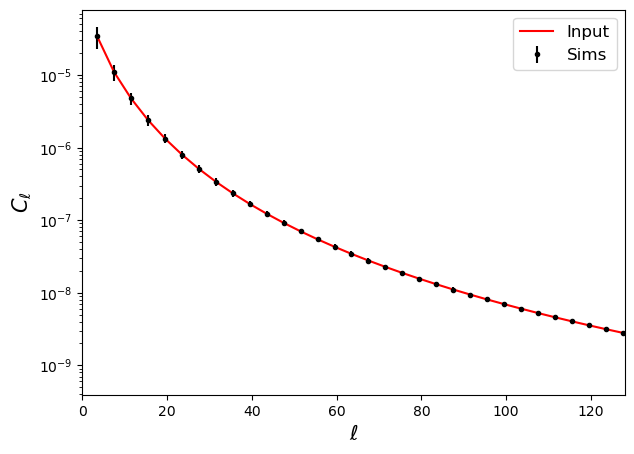

In [5]:
nsims = 10000

# Loop over sims
pcl_sims = []
cl_sims = []
for i in range(nsims):
    mp = gen_sim()
    f = nmt.NmtField(mask, [mp], n_iter=0)
    pcl = nmt.compute_coupled_cell(f, f)
    pcl_sims.append(pcl.squeeze()/fsky)
    cl_sims.append(w.decouple_cell(pcl).squeeze())
cl_sims = np.array(cl_sims)
pcl_sims = np.array(pcl_sims)

# Compute statistics
cl_sims_mean = np.mean(cl_sims, axis=0)
pcl_sims_mean = np.mean(pcl_sims, axis=0)
cov_sims = np.cov(cl_sims.T)

# Plot result
plt.figure(figsize=(7, 5))
plt.errorbar(leff, cl_sims_mean, yerr=np.sqrt(np.diag(cov_sims)), fmt='k.', label='Sims')
plt.plot(leff, w.decouple_cell(w.couple_cell([cl_true]))[0], 'r-', label='Input')
plt.xlim([0, 2*nside])
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.legend(fontsize=12)


Now compute the Gaussian covariance and compare both of them. We will explain the syntax of the `nmt.gaussian_covariance` method in the next section.

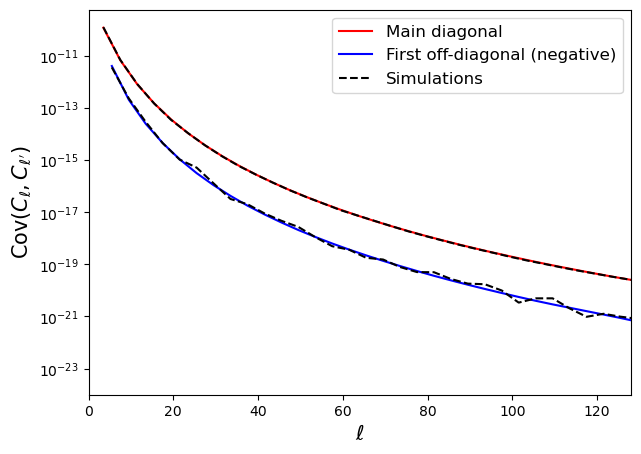

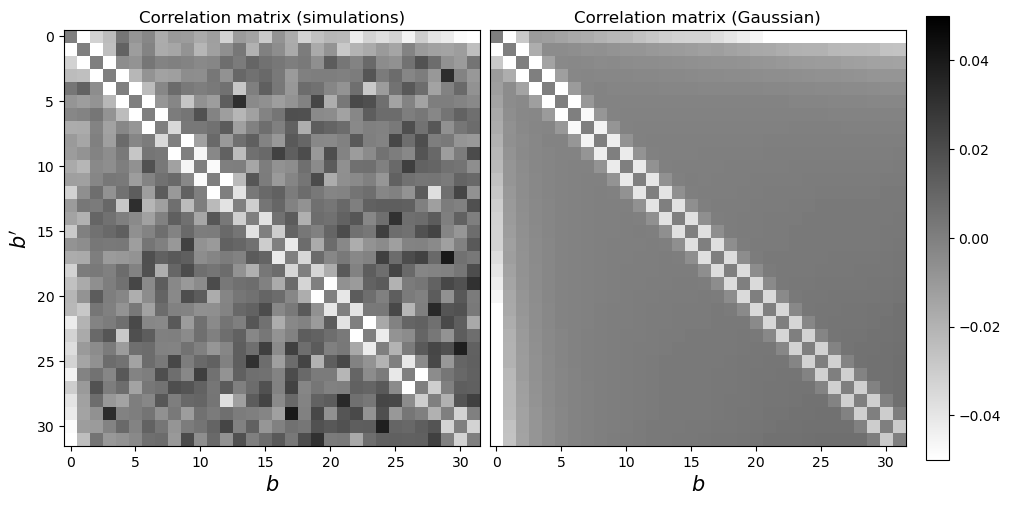

In [6]:
cov_G = nmt.gaussian_covariance(cw, 0, 0, 0, 0,
                                [pcl_sims_mean], [pcl_sims_mean],
                                [pcl_sims_mean], [pcl_sims_mean], w)

# Plot diagonals
plt.figure(figsize=(7, 5))
plt.plot(leff, np.diag(cov_G), 'r-', label='Main diagonal')
plt.plot(leff, np.diag(cov_sims), 'k--')
plt.plot(0.5*(leff[1:]+leff[:-1]), -np.diag(cov_G, k=1), 'b-', label='First off-diagonal (negative)')
plt.plot(0.5*(leff[1:]+leff[:-1]), -np.diag(cov_sims, k=1), 'k--', label='Simulations')
plt.yscale('log')
plt.xlim([0, 2*nside])
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r"${\rm Cov}(C_\ell, C_{\ell'})$", fontsize=15)
plt.legend(fontsize=12)

# Plot full correlation structure
# Restrict to reliable multipoles (ell < 2*nside)
goodl = leff < 2*nside
r_sims = cov_sims/np.sqrt(np.outer(np.diag(cov_sims), np.diag(cov_sims)))
r_sims = r_sims[goodl][:, goodl]
r_G = cov_G/np.sqrt(np.outer(np.diag(cov_G), np.diag(cov_G)))
r_G = r_G[goodl][:, goodl]
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True, layout='constrained')
ax = axes[0]
ax.set_title('Correlation matrix (simulations)')
ax.imshow(r_sims-np.eye(len(r_sims)), vmin=-0.05, vmax=0.05, cmap='binary')
ax.set_xlabel('$b$', fontsize=15)
ax.set_ylabel("$b'$", fontsize=15)
ax = axes[1]
ax.set_title('Correlation matrix (Gaussian)')
im = ax.imshow(r_G-np.eye(len(r_G)), vmin=-0.05, vmax=0.05, cmap='binary')
ax.set_yticks([])
ax.set_xlabel('$b$', fontsize=15)
fig.colorbar(im, ax=ax, location='right', shrink=0.75)


Notice that, above, we have calculated the Gaussian covariance using the $f_{\rm sky}$-corrected, mode-coupled power spectrum as input, instead of the true input power spectrum. This was shown in N20 to be a better choice for the calculation of covariance matrices, and forms the basis of the iNKA. The code below shows explicitly that this is indeed a better approximation (the Gaussian covariance using the true $C_\ell$ achieves a poorer accuracy), and that this can also be achieved by simply mode-coupling the theory spectrum (if you're confident enough that you know what the true spectrum is!).

Note that this effect is slightly exacerbated here because we chose a relatively steep spectrum ($C_\ell\propto\ell^{-4}$), which accentuates all residual mode coupling effects.

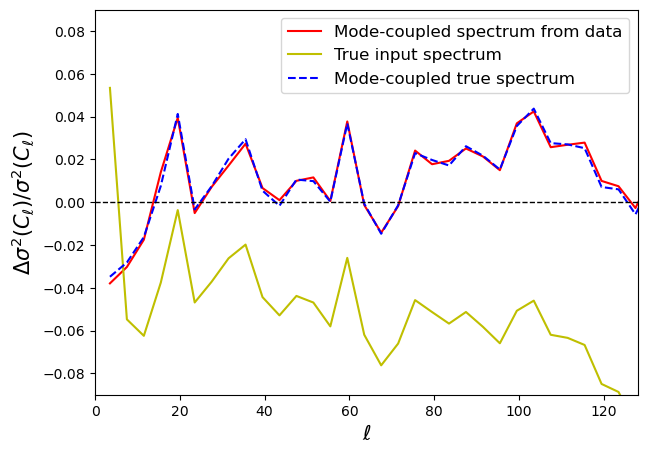

In [7]:
# Gaussian covariance using the true spectrum as input
cov_G2 = nmt.gaussian_covariance(cw, 0, 0, 0, 0,
                                [cl_true], [cl_true],
                                [cl_true], [cl_true], w)

# Gaussian covariance using the mode-coupled true spectrum
pcl_true = w.couple_cell([cl_true])[0]/fsky
cov_G3 = nmt.gaussian_covariance(cw, 0, 0, 0, 0,
                                [pcl_true], [pcl_true],
                                [pcl_true], [pcl_true], w)

plt.figure(figsize=(7, 5))
plt.plot(leff, np.diag(cov_G)/np.diag(cov_sims)-1, 'r-', label='Mode-coupled spectrum from data')
plt.plot(leff, np.diag(cov_G2)/np.diag(cov_sims)-1, 'y-', label='True input spectrum')
plt.plot(leff, np.diag(cov_G3)/np.diag(cov_sims)-1, 'b--', label='Mode-coupled true spectrum')
plt.xlim([0, 2*nside])
plt.ylim([-0.09, 0.09])
plt.axhline(0, c='k', lw=1, ls='--')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r"$\Delta\sigma^2(C_\ell)/\sigma^2(C_\ell)$", fontsize=15)
plt.legend(fontsize=12)


## 3.2 Power spectrum ordering <a class="anchor" id="Ss3.2"></a>
Something that tends to trip users up when trying to calculate Gaussian covariances is the ordering with which power spectra should be passed to NaMaster. Let us consider the most general covariance matrix element, of the form ${\rm Cov}(C_\ell^{a_1a_2}, C_{\ell'}^{b_1b_2})$. I.e. this is the covariance between the power spectrum of fields $(a_1,a_2)$ and that of fields $(b_1,b_2)$.

In the full sky, the Gaussian covariance is given by:
$$
  {\rm Cov}(C_\ell^{a_1a_2},C_{\ell'}^{b_1b_2})=\frac{\delta_{\ell\ell'}}{2\ell+1}\left[C_\ell^{a_1b_1}C_\ell^{a_2b_2}+C_\ell^{a_1b_2}C_\ell^{a_2b_1}\right].
$$
I.e. the covariance depends on four other, potentially distinct, power spectra: $(C_\ell^{a_1b_1},C_\ell^{a_1b_2},C_\ell^{a_2b_1},C_\ell^{a_2b_2})$. In the cut sky, the covariance actually has a similar structure (see G19), so NaMaster also requires you to pass it the same power spectra.

The code below shows how to compute this most general covariance matrix element for 4 fields that are pairwise 30% correlated.

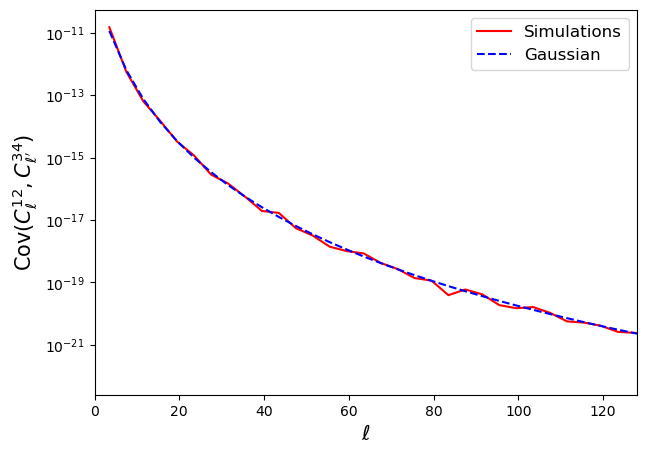

In [8]:
# Generate 1000 sims of 4 correlated maps
clmat = np.array([
    [1.0*cl_true, 0.3*cl_true, 0.3*cl_true, 0.3*cl_true],
    [0.3*cl_true, 1.0*cl_true, 0.3*cl_true, 0.3*cl_true],
    [0.3*cl_true, 0.3*cl_true, 1.0*cl_true, 0.3*cl_true],
    [0.3*cl_true, 0.3*cl_true, 0.3*cl_true, 1.0*cl_true]])


def get_sims():
    alms = hp.synalm([clmat[0, 0], clmat[1, 1], clmat[2, 2], clmat[3, 3],
                      clmat[0, 1], clmat[1, 2], clmat[2, 3],
                      clmat[0, 2], clmat[1, 3],
                      clmat[0, 3]], lmax=3*nside-1, new=True)
    maps = [hp.alm2map(alm, nside) for alm in alms]
    return maps


nsims = 1000
cls_sims = []
for i in range(nsims):
    fs = [nmt.NmtField(mask, [m], n_iter=0) for m in get_sims()]
    cls = np.array([[w.decouple_cell(nmt.compute_coupled_cell(f1, f2))
                     for f2 in fs] for f1 in fs])
    cls_sims.append(cls)
cls_sims = np.array(cls_sims).squeeze()


# Estimate simulated covariance
cls_avg = np.mean(cls_sims, axis=0)
var_1234_sims = np.mean((cls_sims[:, 0, 1, :] - cls_avg[0, 1, :]) *
                        (cls_sims[:, 2, 3, :] - cls_avg[2, 3, :]), axis=0)

# Estimate Gaussian covariance
pcl_13 = w.couple_cell([clmat[0, 2]])/fsky
pcl_14 = w.couple_cell([clmat[0, 3]])/fsky
pcl_23 = w.couple_cell([clmat[1, 2]])/fsky
pcl_24 = w.couple_cell([clmat[1, 3]])/fsky

cov_1234_G = nmt.gaussian_covariance(cw, 0, 0, 0, 0,
                                     pcl_13, pcl_14, pcl_23, pcl_24, w)
plt.figure(figsize=(7, 5))
plt.plot(leff, var_1234_sims, 'r-', label='Simulations')
plt.plot(leff, np.diag(cov_1234_G), 'b--', label='Gaussian')
plt.xlim([0, 2*nside])
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r"${\rm Cov}(C^{12}_\ell,C^{34}_{\ell'})$", fontsize=15)
plt.legend(fontsize=12)
plt.yscale('log')

## 3.3 Covariance of spin fields <a class="anchor" id="Ss3.3"></a>
The covariance of spin-$s$ fields has two additional complications:
- The $B$-mode covariance can sometimes be unreliable.
- The fact that the power spectra of spin-$s$ fields have 4 potentially independent components makes the handling of the covariance matrix a bit more cumbersome.

The code below illustrates these points for a spin-2 field with significant $E$-$B$ asymmetry.

This first block  just sets up the infrastructure to generate the simulations

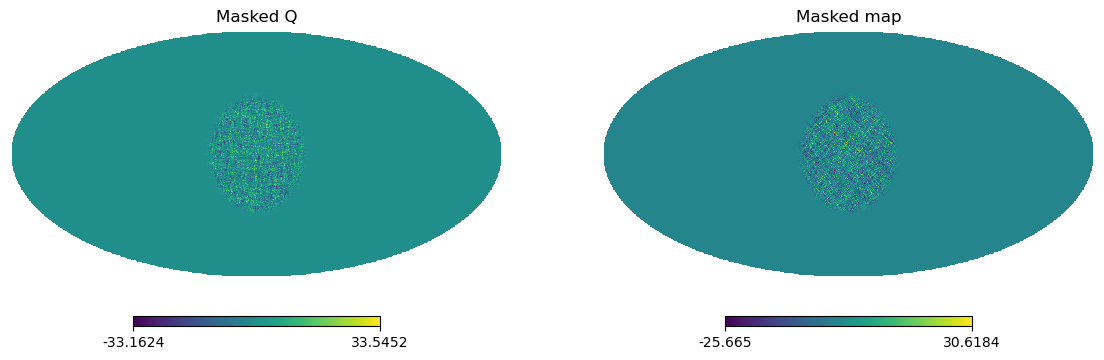

In [9]:
nside = 256
npix = hp.nside2npix(nside)
ls = 3*nside

# Range of ells to explore and input power spectrum
ls = np.arange(3*nside)
cl_ee = 1/(ls+10)
cl_bb = 0.01*cl_ee
cl_ee[:2] = 0
cl_bb[:2] = 0

# Binary mask
nside_hi = 512
npix_hi = hp.nside2npix(nside_hi)
mask_binary = np.zeros(npix_hi)
mask_binary[hp.query_disc(nside_hi, [1, 0, 0], np.radians(40))] = 1

# Apodised mask
# We use a 5-degree "C1" apodisation (see Grain et al. 2009).
mask = hp.ud_grade(nmt.mask_apodization(mask_binary, 10.0, "C1"), nside_out=nside)
maskbin = mask > 0

# Simulator
def gen_sim():
    elm, blm = hp.synalm([cl_ee, cl_bb, 0*cl_ee],
                         lmax=3*nside-1, new=True)
    qmap, umap = hp.alm2map_spin([elm, blm], nside, 2, lmax=3*nside-1)
    return qmap, umap


fig, axes = plt.subplots(1, 2, figsize=(14, 10))
q, u = gen_sim()
plt.axes(axes[0])
hp.mollview(q*mask, title='Masked Q', hold=True)
plt.axes(axes[1])
hp.mollview(u*mask, title='Masked map', hold=True)

Now let us compute the $E$ and $B$ power spectra for 1000 realisations. We'll check the result of using $B$-mode purification or not.

In [10]:
# Binning
delta_ell = 30
b = nmt.NmtBin.from_nside_linear(nside, nlb=delta_ell)

# MCMs
f = nmt.NmtField(mask, None, spin=2)
w = nmt.NmtWorkspace.from_fields(f, f, b)
f = nmt.NmtField(mask, None, spin=2, purify_b=True)
wp = nmt.NmtWorkspace.from_fields(f, f, b)

# Sims
nsims = 100
cl_sims = []
cl_sims_pure = []
for i in range(nsims):
    q, u = gen_sim()
    q *= maskbin
    u *= maskbin
    f2 = nmt.NmtField(mask, [q, u])
    f2p = nmt.NmtField(mask, [q, u], purify_b=True)
    cl = w.decouple_cell(nmt.compute_coupled_cell(f2, f2))
    clp = wp.decouple_cell(nmt.compute_coupled_cell(f2p, f2p))
    cl_sims.append(cl)
    cl_sims_pure.append(clp)
cl_sims = np.array(cl_sims)
cl_sims_pure = np.array(cl_sims_pure)

# Variance from simulations
var_ee_sims = np.std(cl_sims[:, 0, :], axis=0)**2
var_bb_sims = np.std(cl_sims[:, 3, :], axis=0)**2
var_bbp_sims = np.std(cl_sims_pure[:, 3, :], axis=0)**2

Now let us compare the power spectrum uncertainties with the Gaussian prediction in two different approximations:
- Treating $E$ and $B$ as independent scalar fields.
- Treating $E$ and $B$ as the two spherical harmonic components of a spin-2 field.

Note that, due to the approximations inherent in the NKA, the second option is not necessarily more accurate than the first one (although it is for the example below). This is discussed in G19 and N20.

Let us explore these options for the $EE$ and $BB$ spectra with and without purification. Pay attention below to how the covariance matrix indices for spin-2 fields are handled!

In [11]:
# Compute mode-coupled input spectra for the iNKA
fsky = np.mean(mask**2)
pcl_true = w.couple_cell([cl_ee, 0*cl_ee, 0*cl_ee, cl_bb])/fsky
pcl_true_pure = wp.couple_cell([cl_ee, 0*cl_ee, 0*cl_ee, cl_bb])/fsky

# Compute covariance workspaces
# As scalar fields
f = nmt.NmtField(mask, None, spin=0)
w0 = nmt.NmtWorkspace.from_fields(f, f, b)
pcl_ee = w0.couple_cell([cl_ee])/fsky
pcl_bb = w0.couple_cell([cl_bb])/fsky
cw0 = nmt.NmtCovarianceWorkspace.from_fields(f, f)
# As spin-2 fields
f = nmt.NmtField(mask, None, spin=2)
cw2 = nmt.NmtCovarianceWorkspace.from_fields(f, f)

# Gaussian covariance as scalar fields
# EE
cov = nmt.gaussian_covariance(cw0, 0, 0, 0, 0, pcl_ee, pcl_ee, pcl_ee, pcl_ee, w0)
var_ee_G_0 = np.diag(cov)
# BB
cov = nmt.gaussian_covariance(cw0, 0, 0, 0, 0, pcl_bb, pcl_bb, pcl_bb, pcl_bb, w0)
var_bb_G_0 = np.diag(cov)

# Gaussian covariance as single spin-2 field with no purification
cov = nmt.gaussian_covariance(cw2, 2, 2, 2, 2, pcl_true, pcl_true, pcl_true, pcl_true, w)
# See what the ordering of the spin-2 covariance is below
nbpw = b.get_n_bands()
cov = cov.reshape([nbpw, 4, nbpw, 4])
var_ee_G_2 = np.diag(cov[:, 0, :, 0])
var_bb_G_2 = np.diag(cov[:, 3, :, 3])

# Gaussian covariance as single spin-2 field with purification
cov = nmt.gaussian_covariance(cw2, 2, 2, 2, 2, pcl_true_pure, pcl_true_pure, pcl_true_pure, pcl_true_pure, wp)
nbpw = b.get_n_bands()
cov = cov.reshape([nbpw, 4, nbpw, 4])
var_bbp_G_2 = np.diag(cov[:, 3, :, 3])

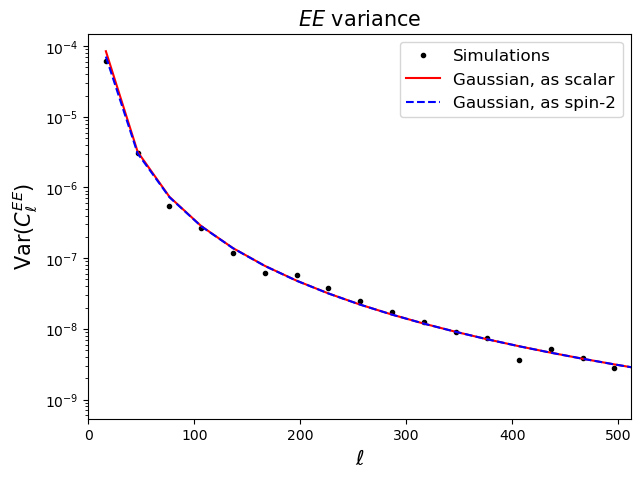

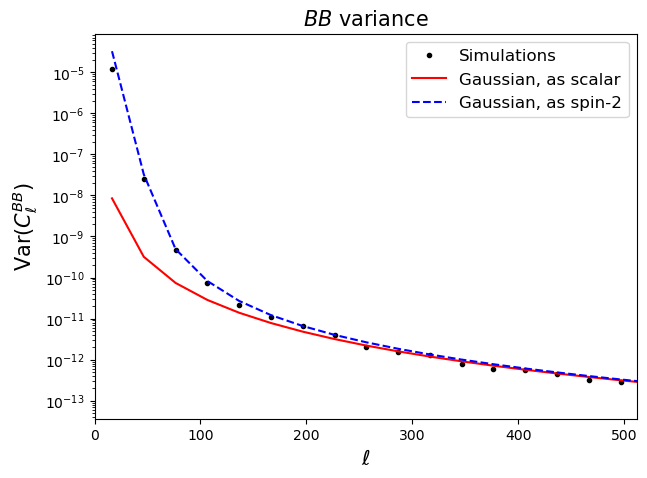

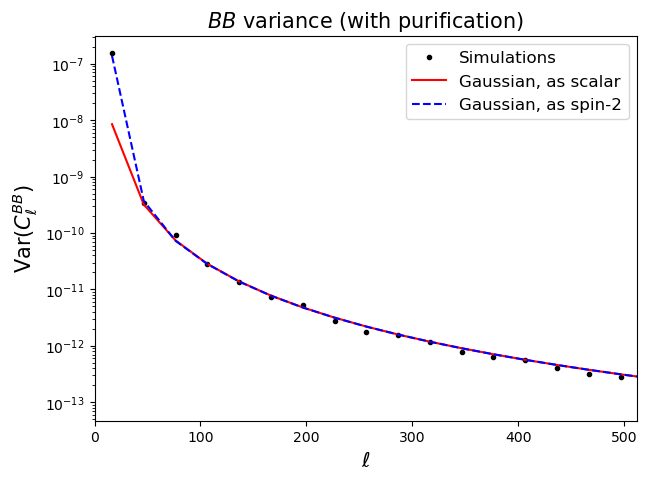

In [12]:
leff = b.get_effective_ells()

plt.figure(figsize=(7, 5))
plt.title('$EE$ variance', fontsize=15)
plt.plot(leff, var_ee_sims, 'k.', label='Simulations')
plt.plot(leff, var_ee_G_0, 'r-', label='Gaussian, as scalar')
plt.plot(leff, var_ee_G_2, 'b--', label='Gaussian, as spin-2')
plt.yscale('log')
plt.xlim([0, 2*nside])
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r"${\rm Var}(C^{EE}_\ell)$", fontsize=15)
plt.legend(fontsize=12)

plt.figure(figsize=(7, 5))
plt.title('$BB$ variance', fontsize=15)
plt.plot(leff, var_bb_sims, 'k.', label='Simulations')
plt.plot(leff, var_bb_G_0, 'r-', label='Gaussian, as scalar')
plt.plot(leff, var_bb_G_2, 'b--', label='Gaussian, as spin-2')
plt.yscale('log')
plt.xlim([0, 2*nside])
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r"${\rm Var}(C^{BB}_\ell)$", fontsize=15)
plt.legend(fontsize=12)

plt.figure(figsize=(7, 5))
plt.title('$BB$ variance (with purification)', fontsize=15)
plt.plot(leff, var_bbp_sims, 'k.', label='Simulations')
plt.plot(leff, var_bb_G_0, 'r-', label='Gaussian, as scalar')
plt.plot(leff, var_bbp_G_2, 'b--', label='Gaussian, as spin-2')
plt.yscale('log')
plt.xlim([0, 2*nside])
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r"${\rm Var}(C^{BB}_\ell)$", fontsize=15)
plt.legend(fontsize=12)
